This example conducts a statistical analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on April 14, 2020.

In [82]:
import csv
import datetime
import random
import sqlite3
import sys
import time

import pandas as pd
import numpy as np
from optwrf.runwrf import WRFModel
import optwrf.simplega as simplega
from optwrf.simplega import Chromosome
import optwrf.wrfparams as wrfparams
import optwrf.optimize_wrf_physics as owp

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [88]:
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)

dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_041420_10am.csv', parse_dates=['start_date'], date_parser=dateparse)

In [89]:
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
0,2011-12-29,2,31,2,3,5,93,1,6.022000e+23,00:00:00
1,2011-11-27,13,5,7,5,5,14,1,2.034423e+03,4:39:34.359051
2,2011-09-01,14,4,7,1,1,11,2,6.022000e+23,0:00:00.042498
3,2011-04-06,18,1,5,7,9,16,1,6.022000e+23,6:00:01.733799
4,2011-05-02,14,7,1,7,8,94,1,6.022000e+23,6:00:06.829933
...,...,...,...,...,...,...,...,...,...,...
397,2011-10-12,16,4,5,2,12,14,1,7.784568e+02,02h 26m 46s
398,2011-08-12,16,4,5,4,2,14,1,6.022000e+23,00h 00m 00s
399,2011-10-26,5,4,7,1,12,7,1,6.022000e+23,00h 00m 00s
400,2011-01-12,18,5,4,7,9,99,1,9.809773e+02,02h 34m 53s


In [90]:
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00
1,2011-11-27,13,5,7,5,5,14,1,2034.423190,4:39:34.359051
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933
...,...,...,...,...,...,...,...,...,...,...
397,2011-10-12,16,4,5,2,12,14,1,778.456764,02h 26m 46s
398,2011-08-12,16,4,5,4,2,14,1,NaN,00h 00m 00s
399,2011-10-26,5,4,7,1,12,7,1,NaN,00h 00m 00s
400,2011-01-12,18,5,4,7,9,99,1,980.977345,02h 34m 53s


In [91]:
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime
37,2011-01-01,8,4,99,5,9,7,1,1432.446184,5:22:22.863760
33,2011-01-01,18,3,4,7,9,7,1,NaN,6:00:02.341057
203,2011-01-01,6,5,99,7,9,1,1,NaN,06h 00m 08s
305,2011-01-02,11,4,4,2,12,5,1,710.210094,03h 44m 48s
361,2011-01-02,6,1,4,4,12,16,1,630.713944,01h 14m 12s
...,...,...,...,...,...,...,...,...,...,...
129,2011-12-27,17,7,1,2,7,1,1,1033.922806,02h 16m 35s
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00
108,2011-12-30,2,4,24,5,9,94,1,890.534170,05h 09m 23s
56,2011-12-30,10,31,3,4,7,5,1,NaN,00h 52m 31s


2011-01-01T00:00
2011-12-30T00:01


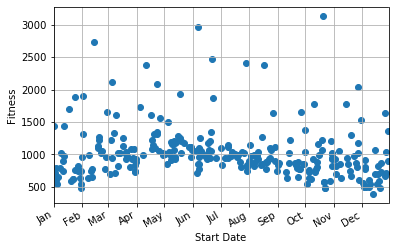

In [113]:
fig, ax = plt.subplots()
plt.scatter(start_date, fitness)
plt.xlabel('Start Date')
plt.ylabel('Fitness')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%b')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)

# round to nearest month
datemin = np.datetime64(data['start_date'].iloc[0], 'm')
print(datemin)
datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
print(datemax)
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()